<a href="https://colab.research.google.com/github/mohibwaqarr/DVLM_Assignment0/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 15
LATENT_DIM = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)

        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 784)

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

print("VAE Model defined successfully.")

Using device: cuda


100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.76MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 58.2MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.7MB/s]


VAE Model defined successfully.


In [ ]:
model = VAE(input_dim=784, hidden_dim=400, latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history = {
    'total_loss': [],
    'bce_loss': [],
    'kld_loss': []
}

print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_bce = 0
    train_kld = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()

        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce = train_bce / len(train_loader.dataset)
    avg_kld = train_kld / len(train_loader.dataset)

    history['total_loss'].append(avg_loss)
    history['bce_loss'].append(avg_bce)
    history['kld_loss'].append(avg_kld)

    print(f'Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Recon (BCE): {avg_bce:.4f} | KL Div: {avg_kld:.4f}')

print("Training Complete!")

Starting Training...
Epoch 1/15 | Loss: 285.7520 | Recon (BCE): 271.2155 | KL Div: 14.5365
Epoch 2/15 | Loss: 256.8551 | Recon (BCE): 241.0962 | KL Div: 15.7588
Epoch 3/15 | Loss: 250.9475 | Recon (BCE): 235.2385 | KL Div: 15.7090
Epoch 4/15 | Loss: 248.0730 | Recon (BCE): 232.2466 | KL Div: 15.8264
Epoch 5/15 | Loss: 246.3753 | Recon (BCE): 230.4004 | KL Div: 15.9749
Epoch 6/15 | Loss: 245.2647 | Recon (BCE): 229.1756 | KL Div: 16.0891
Epoch 7/15 | Loss: 244.3990 | Recon (BCE): 228.2141 | KL Div: 16.1849
Epoch 8/15 | Loss: 243.8153 | Recon (BCE): 227.5538 | KL Div: 16.2614
Epoch 9/15 | Loss: 243.2523 | Recon (BCE): 226.9535 | KL Div: 16.2988
Epoch 10/15 | Loss: 242.8507 | Recon (BCE): 226.4994 | KL Div: 16.3513
Epoch 11/15 | Loss: 242.5174 | Recon (BCE): 226.1266 | KL Div: 16.3909
Epoch 12/15 | Loss: 242.2225 | Recon (BCE): 225.7986 | KL Div: 16.4239
Epoch 13/15 | Loss: 241.9071 | Recon (BCE): 225.4734 | KL Div: 16.4337
Epoch 14/15 | Loss: 241.6514 | Recon (BCE): 225.2254 | KL Div: 16

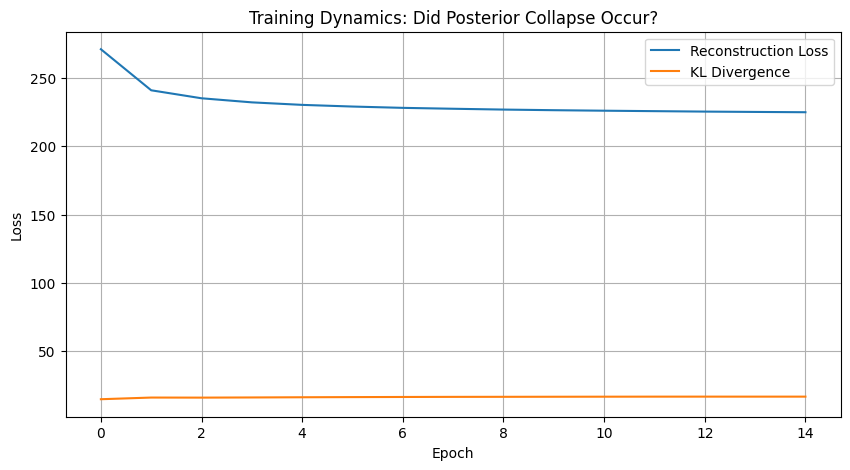

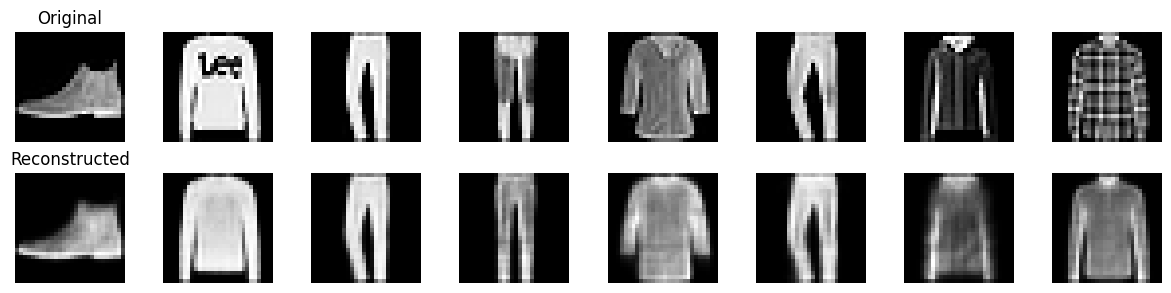

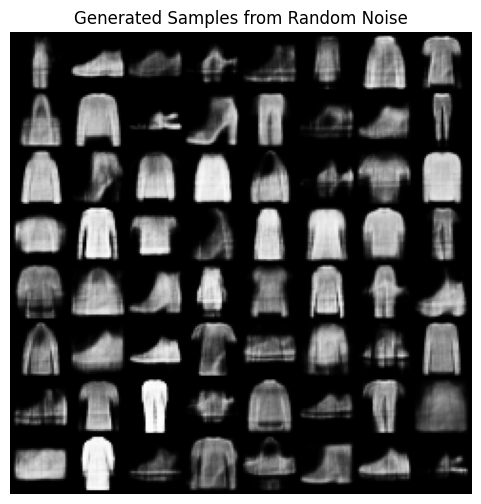

In [ ]:
model.eval()

plt.figure(figsize=(10, 5))
plt.plot(history['bce_loss'], label='Reconstruction Loss')
plt.plot(history['kld_loss'], label='KL Divergence')
plt.title("Training Dynamics: Did Posterior Collapse Occur?")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("vae_training_curves.png")
plt.show()

with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(DEVICE)

    recon, _, _ = model(data)

    data = data.cpu().numpy()
    recon = recon.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    for i in range(8):
        axes[0, i].imshow(data[i][0], cmap='gray')
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Original")

        axes[1, i].imshow(recon[i][0], cmap='gray')
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.savefig("vae_reconstructions.png")
    plt.show()

with torch.no_grad():
    z = torch.randn(64, LATENT_DIM).to(DEVICE)
    sample = model.decode(z).cpu()

    fig, ax = plt.subplots(figsize=(6, 6))
    from torchvision.utils import make_grid
    grid_img = make_grid(sample.view(64, 1, 28, 28), nrow=8)

    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title("Generated Samples from Random Noise")
    plt.savefig("vae_generation.png")
    plt.show()

Generating Latent Space Visualization (t-SNE)...


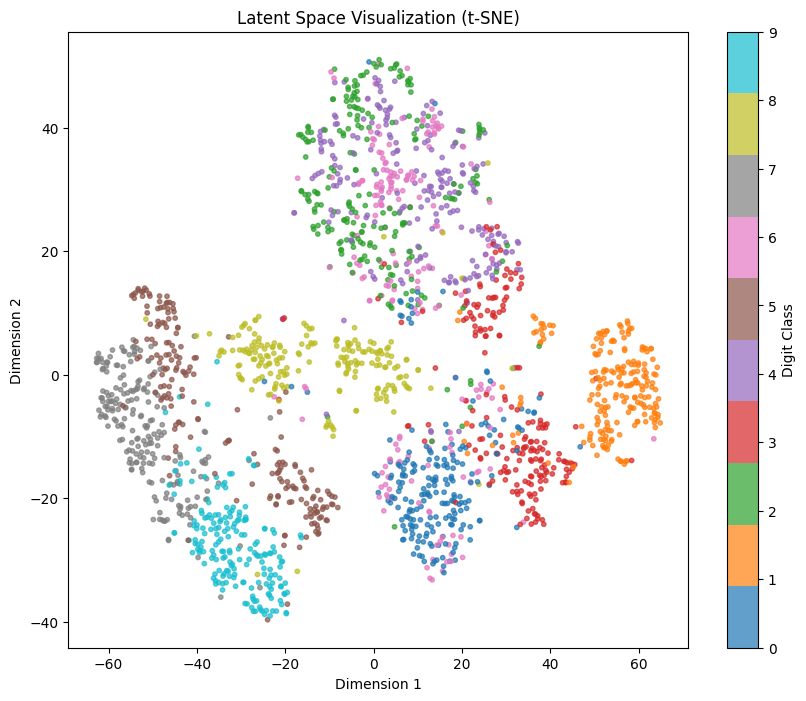

Done! Upload 'vae_latent_space.png'.


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

print("Generating Latent Space Visualization (t-SNE)...")

latents = []
labels = []

model.eval()
with torch.no_grad():
    for i, (data, targets) in enumerate(test_loader):
        if i * BATCH_SIZE >= 2000:
            break
        data = data.to(DEVICE)

        mu, _ = model.encode(data.view(-1, 784))

        latents.append(mu.cpu().numpy())
        labels.append(targets.numpy())

latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
plt.colorbar(scatter, ticks=range(10), label='Digit Class')
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig("vae_latent_space.png")
plt.show()
print("Done! Upload 'vae_latent_space.png'.")